<a href="https://colab.research.google.com/github/segedakate2005/-/blob/main/%D0%BB%D0%B0%D0%B1_12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
moazeldsokyx_dogs_vs_cats_path = kagglehub.dataset_download('moazeldsokyx/dogs-vs-cats')

print('Data source import complete.')

Data source import complete.


In [ ]:
moazeldsokyx_dogs_vs_cats_path

'/kaggle/input/dogs-vs-cats'

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'   # 0 = all messages, 3 = only errors
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [ ]:
train_dir = moazeldsokyx_dogs_vs_cats_path+'/dataset/train'
val_dir = moazeldsokyx_dogs_vs_cats_path+'/dataset/validation'
test_dir =moazeldsokyx_dogs_vs_cats_path+'/dataset/test'

In [ ]:
class_names = ['Cat', 'Dog']
# Генератор для тренування з аугментацією + нормалізацією для VGG16

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

# Генератор для валідації і тесту — тільки нормалізація

val_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Генератор для тренувального набору

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # Рекомендований розмір для VGG16
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

# Генератор для валідаційного набору

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

# Генератор для тестового набору

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Found 12461 images belonging to 2 classes.


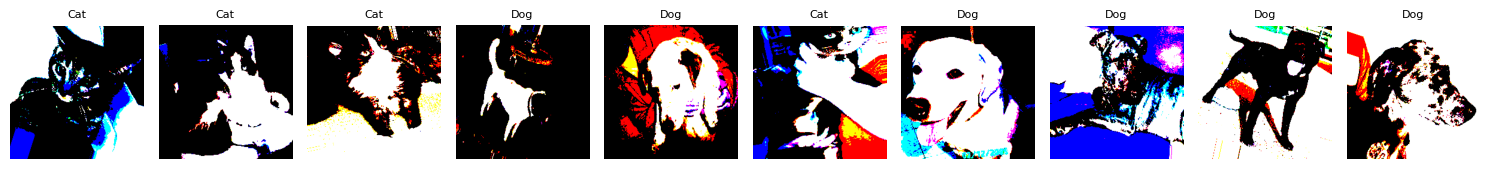

In [ ]:
# Отримуємо новий набір зображень
images, labels = next(train_generator)

# Випадкові індекси для 10 зображень
indices = np.random.choice(len(images), size=10, replace=False)

# Візуалізація
plt.figure(figsize=(15, 3))
for i, idx in enumerate(indices):
    plt.subplot(1, 10, i + 1)
    plt.imshow(images[idx])
    plt.axis('off')
    plt.title(class_names[int(labels[idx])], fontsize=8)
plt.tight_layout()
plt.show()

In [ ]:
base_model = VGG16(
    weights='imagenet',
    include_top=False,           # Ми додаємо свої класифікатори
    input_shape=(224, 224, 3)
)

# Заморожуємо всі шари базової VGG16
for layer in base_model.layers:
    layer.trainable = False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',       # Слідкуємо за валідаційною втратою
    patience=5,               # Скільки епох чекати без покращення
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,               # Зменшення LR у 5 разів
    patience=3,               # Якщо за 3 епохи немає покращення
    min_lr=1e-6               # Мінімально допустимий learning rate
)

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=5,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    # callbacks=[early_stopping, reduce_lr]
)

Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 312s 499ms/step - accuracy: 0.9828 - loss: 0.0456 - val_accuracy: 0.9860 - val_loss: 0.0625
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 314s 502ms/step - accuracy: 0.9842 - loss: 0.0412 - val_accuracy: 0.9854 - val_loss: 0.0629
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 314s 502ms/step - accuracy: 0.9862 - loss: 0.0367 - val_accuracy: 0.9854 - val_loss: 0.0673
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 331s 517ms/step - accuracy: 0.9868 - loss: 0.0354 - val_accuracy: 0.9862 - val_loss: 0.0626
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 375s 506ms/step - accuracy: 0.9858 - loss: 0.0405 - val_accuracy: 0.9862 - val_loss: 0.0772


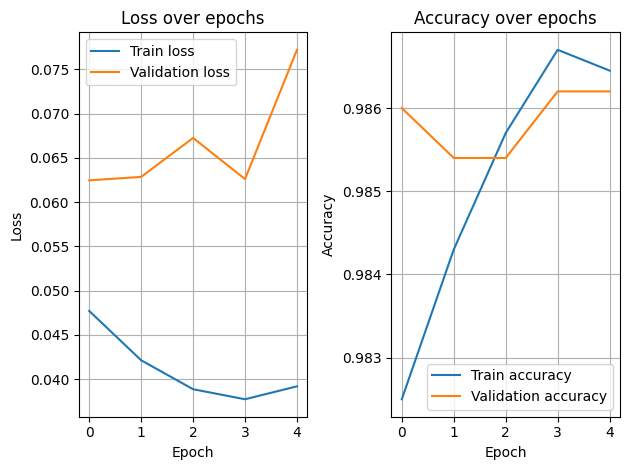

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Loss over epochs')
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Криві точності
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


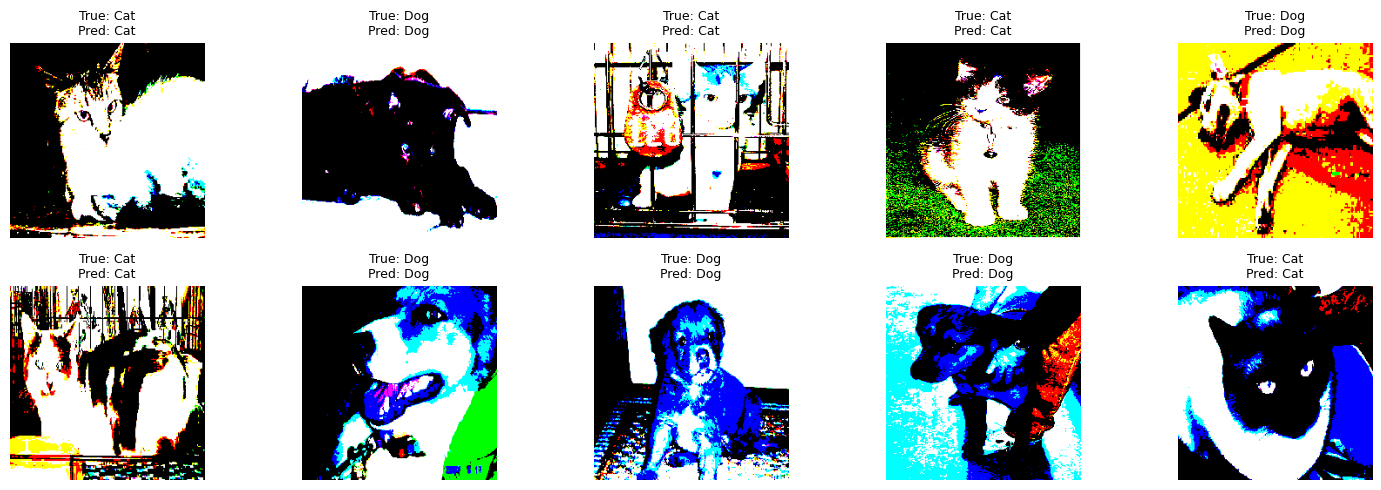

In [ ]:
# Отримуємо batch із тестового генератора
images, true_labels = next(test_generator)

# Робимо передбачення
pred_probs = model.predict(images)
pred_labels = (pred_probs > 0.5).astype(int).reshape(-1)

# Назви класів
class_names = ['Cat', 'Dog']

# Показуємо перші 10 зображень
plt.figure(figsize=(15, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i])
    plt.axis('off')
    true_class = class_names[int(true_labels[i])]
    pred_class = class_names[int(pred_labels[i])]
    plt.title(f"True: {true_class}\nPred: {pred_class}", fontsize=9)
plt.tight_layout()
plt.show()

In [ ]:
# Завантаження базової VGG16 без класифікатора
base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# ❄️ Заморожуємо тільки нижні шари, а верхні розморозимо для fine-tuning
for layer in base_model.layers[:15]:
    layer.trainable = False
for layer in base_model.layers[15:]:
    layer.trainable = True

# 🔁 Замість Flatten краще використовувати GlobalAveragePooling2D
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

# Створення фінальної моделі
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=5,
    validation_data=val_generator,
    validation_steps=len(val_generator),
)

Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 333s 522ms/step - accuracy: 0.9302 - loss: 0.2179 - val_accuracy: 0.9826 - val_loss: 0.0537
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 381s 528ms/step - accuracy: 0.9769 - loss: 0.0598 - val_accuracy: 0.9854 - val_loss: 0.0499
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 329s 526ms/step - accuracy: 0.9825 - loss: 0.0446 - val_accuracy: 0.9724 - val_loss: 0.1111
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 367s 502ms/step - accuracy: 0.9844 - loss: 0.0447 - val_accuracy: 0.9896 - val_loss: 0.0516
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 325s 507ms/step - accuracy: 0.9890 - loss: 0.0268 - val_accuracy: 0.9792 - val_loss: 0.0791


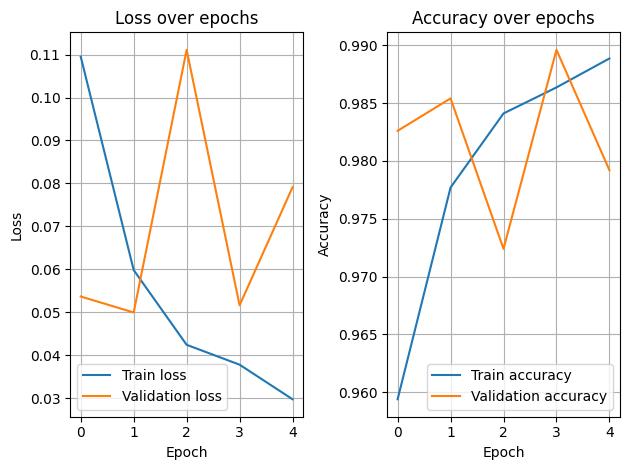

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Loss over epochs')
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Криві точності
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


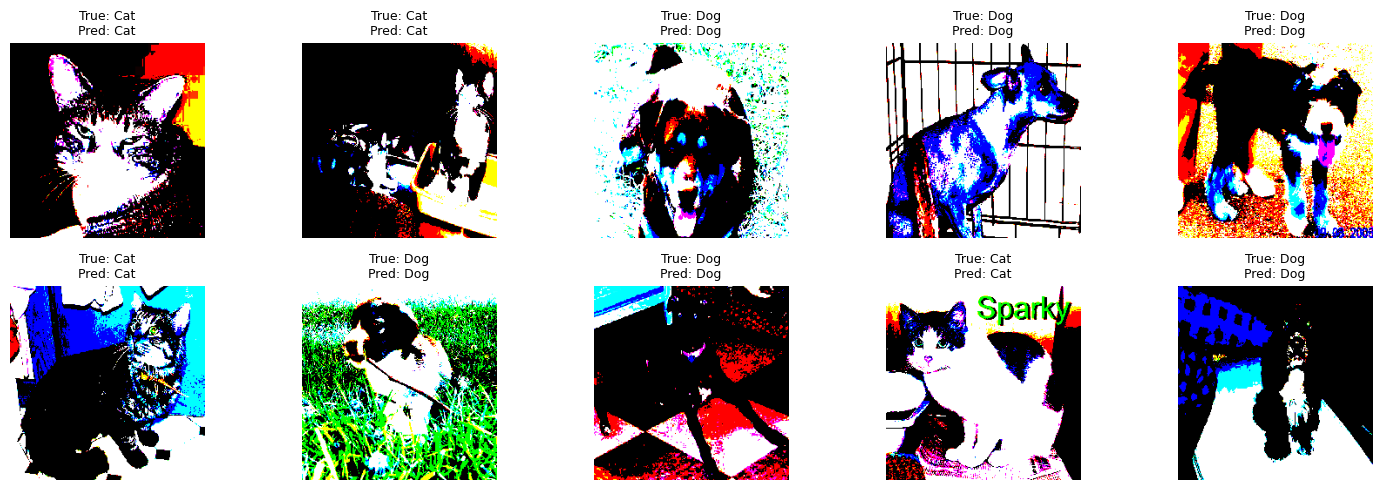

In [ ]:
# Отримуємо batch із тестового генератора
images, true_labels = next(test_generator)

# Робимо передбачення
pred_probs = model.predict(images)
pred_labels = (pred_probs > 0.5).astype(int).reshape(-1)

# Назви класів
class_names = ['Cat', 'Dog']

# Показуємо перші 10 зображень
plt.figure(figsize=(15, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i])
    plt.axis('off')
    true_class = class_names[int(true_labels[i])]
    pred_class = class_names[int(pred_labels[i])]
    plt.title(f"True: {true_class}\nPred: {pred_class}", fontsize=9)
plt.tight_layout()
plt.show()